# 📊 Model Evaluation & Inference

**Project:** German Traffic Sign Recognition Benchmark (GTSRB)  
**Model:** ResNet18 (Transfer Learning)

### 🎯 Objectives
In this final notebook, we evaluate the performance of our trained model. We move beyond simple training metrics to understand **how** the model behaves.
1.  **Quantitative Analysis:** Calculate accuracy on the **Validation Set** (internal check) and the **Official Test Set** (external check).
2.  **Qualitative Analysis:** Use a **Confusion Matrix** to visualize which classes confuse the model.
3.  **Error Analysis:** Inspect specific images where the model failed to understand *why*.
4.  **Real-World Inference:** Test the model on internet images to demonstrate the importance of preprocessing (cropping).

In [1]:
import sys
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# 1. Setup Project Path
project_root = str(Path.cwd().parent.resolve())
if project_root not in sys.path:
    sys.path.append(project_root)

from src.model import GTSRBNet
from src.dataset import GTSRBDataset

# 2. Configuration
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
BATCH_SIZE = 64
SEED = 42

# 3. Reproducibility (Critical for matching the Validation Split)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"✅ Running analysis on device: {DEVICE}")

✅ Running analysis on device: mps


In [2]:
# Map Class IDs to Readable Names
classes = { 
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)', 
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection', 
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 17:'No entry', 18:'General caution', 
    19:'Dangerous curve left', 20:'Dangerous curve right', 21:'Double curve', 
    22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 
    38:'Keep right', 39:'Keep left', 40:'Roundabout mandatory', 
    41:'End of no passing', 42:'End no passing veh > 3.5 tons' 
}

## 1. Load Trained Model
We initialize the ResNet18 architecture and load the best weights saved during the training phase (`gtsrb_best_model.pth`).

In [3]:
# Initialize Architecture
model = GTSRBNet(num_classes=43)

# Load Weights
model_path = '../models/gtsrb_best_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval() # Set to evaluation mode (Disables Dropout/Batch Norm updates)
    print("✅ Model loaded successfully.")
else:
    raise FileNotFoundError(f"❌ Model file not found at {model_path}. Did you train the model?")

Loading pre-trained ResNet18 weights...
✅ Model loaded successfully.


## 2. Prepare DataLoaders
To accurately evaluate the model, we must:
1.  **Reconstruct the Validation Set:** We must use the exact same random seed (`42`) and split logic used during training to ensure we are testing on the correct "hold-out" data.
2.  **Load the Test Set:** This is the official GTSRB Test dataset, which contains completely unseen images.

In [4]:
# Standard Transform (No Augmentation)
eval_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- A. Validation Set ---
train_dataset = GTSRBDataset(
    csv_file='../data/GTSRB/Train.csv', 
    root_dir='../data/GTSRB', 
    transform=eval_transform
)

# Replicate the shuffle and split from training
indices = list(range(len(train_dataset)))
split = int(np.floor(0.2 * len(train_dataset)))
np.random.shuffle(indices) # Crucial: Shuffle using same seed
val_indices = indices[:split]

val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

# --- B. Official Test Set ---
test_csv_path = '../data/GTSRB/Test.csv'
test_loader = None

if os.path.exists(test_csv_path):
    test_dataset = GTSRBDataset(
        csv_file=test_csv_path, 
        root_dir='../data/GTSRB', 
        transform=eval_transform
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"📊 Validation Images: {len(val_indices)} | Test Images: {len(test_dataset)}")
else:
    print("⚠️ Test.csv not found. Skipping Test Set evaluation.")

📊 Validation Images: 7841 | Test Images: 12630


## 3. Quantitative Evaluation
We run the model over both datasets to calculate the final **Accuracy**.

In [5]:
def evaluate_model(loader, model, device):
    all_preds = []
    all_labels = []
    
    print("Running inference...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    # Calculate Accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    accuracy = np.sum(all_preds == all_labels) / len(all_labels)
    
    return accuracy, all_preds, all_labels

# 1. Validation Results
print("\n--- 🔍 Validation Set Results ---")
val_acc, val_preds, val_labels = evaluate_model(val_loader, model, DEVICE)
print(f"🏆 Validation Accuracy: {val_acc:.2%}")

# 2. Test Results
if test_loader:
    print("\n--- 🌟 Official Test Set Results ---")
    test_acc, test_preds, test_labels = evaluate_model(test_loader, model, DEVICE)
    print(f"🏆 Final Test Accuracy: {test_acc:.2%}")


--- 🔍 Validation Set Results ---
Running inference...
🏆 Validation Accuracy: 99.99%

--- 🌟 Official Test Set Results ---
Running inference...
🏆 Final Test Accuracy: 99.34%


## 4. Visual Analysis: Confusion Matrix
A heatmap showing the correlation between True labels and Predicted labels. A perfect model would show a bright diagonal line.

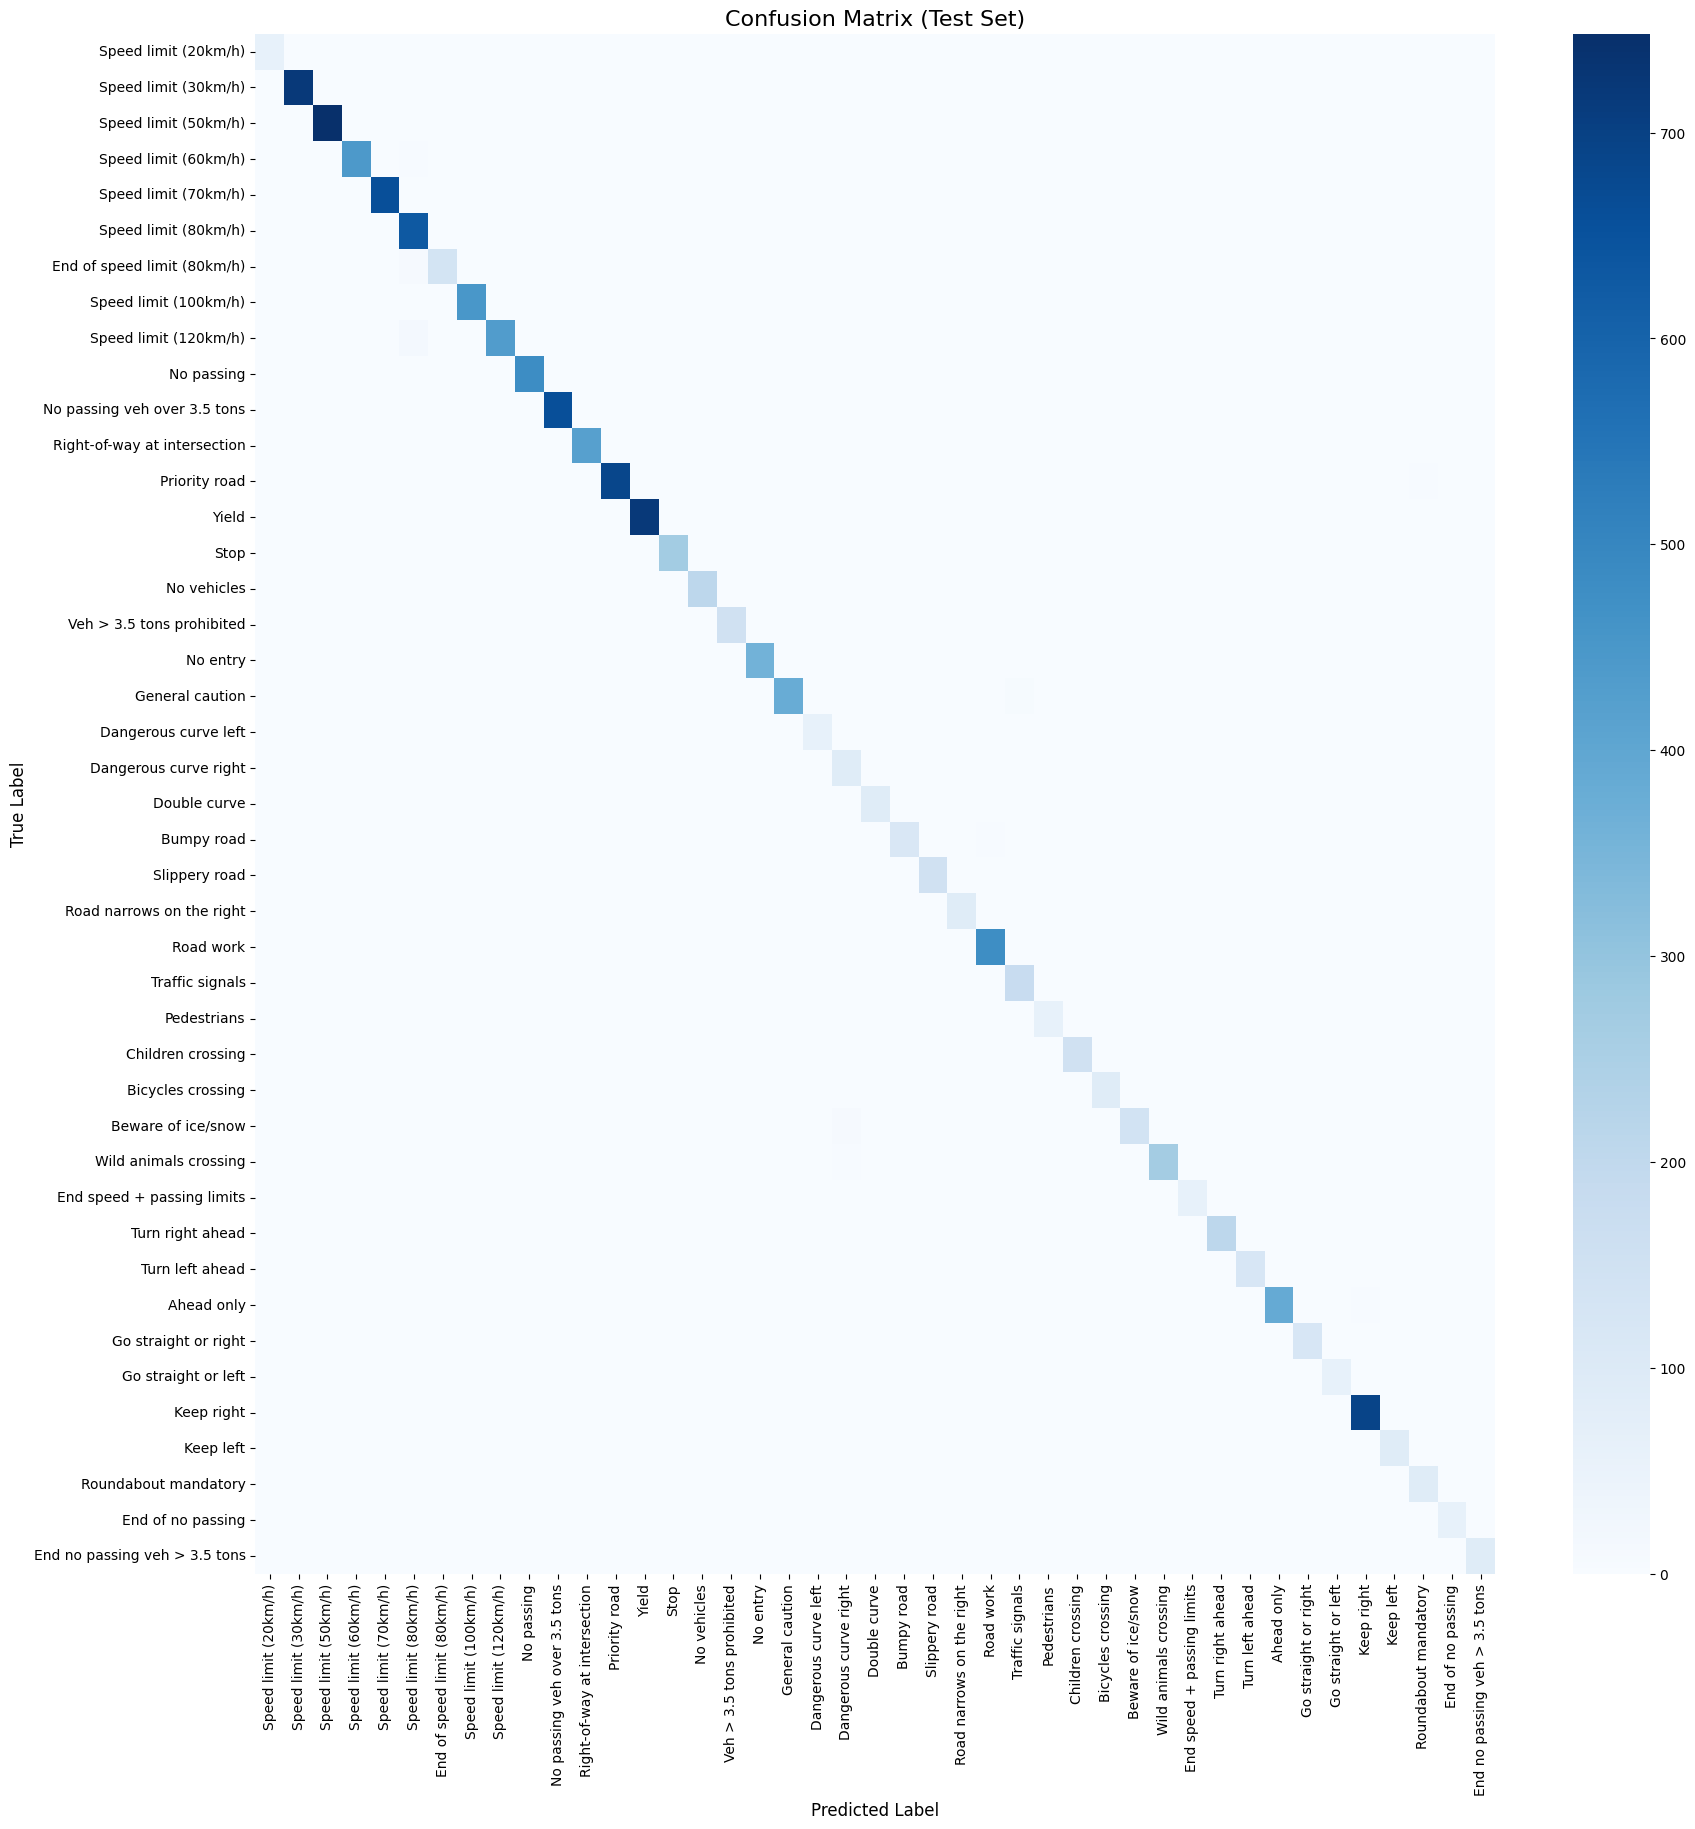

In [7]:
# Select data to plot (Test set preferred, fallback to Val)
labels_to_plot = test_labels if test_loader else val_labels
preds_to_plot = test_preds if test_loader else val_preds
dataset_name = "Test Set" if test_loader else "Validation Set"

# Compute Confusion Matrix
cm = confusion_matrix(labels_to_plot, preds_to_plot)

# Plot
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=classes.values(), yticklabels=classes.values())
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix ({dataset_name})', fontsize=16)
plt.show()